In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/Sensei/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [38]:
def no_impute(dataset):
    df = dataset.replace({'?': np.nan}).apply(pd.to_numeric)
    return df[['Age', 'Shape', 'Margin', 'Density']], df['Severity']

def preprocess(dataset):
    df = dataset.replace({'?': None}).dropna()
    return df[['Age', 'Shape', 'Margin', 'Density']], df['Severity']

def preprocess_impute(dataset):
    df = dataset.replace({'?': np.nan}).apply(pd.to_numeric)
    df = df.fillna(df.mode().transpose()[0])
    return df[['Age', 'Shape', 'Margin', 'Density']], df['Severity']

## Testing

In [15]:
dpath = "../data/part1_data"
X_train, y_train = preprocess_impute(pd.read_csv(f"{dpath}/train.csv"))
X_val, y_val = preprocess_impute(pd.read_csv(f"{dpath}/val.csv"))
X_test, y_test = preprocess_impute(pd.read_csv(f"{dpath}/test.csv"))
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      537 non-null    float64
 1   Shape    537 non-null    float64
 2   Margin   537 non-null    float64
 3   Density  537 non-null    float64
dtypes: float64(4)
memory usage: 16.9 KB


In [16]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

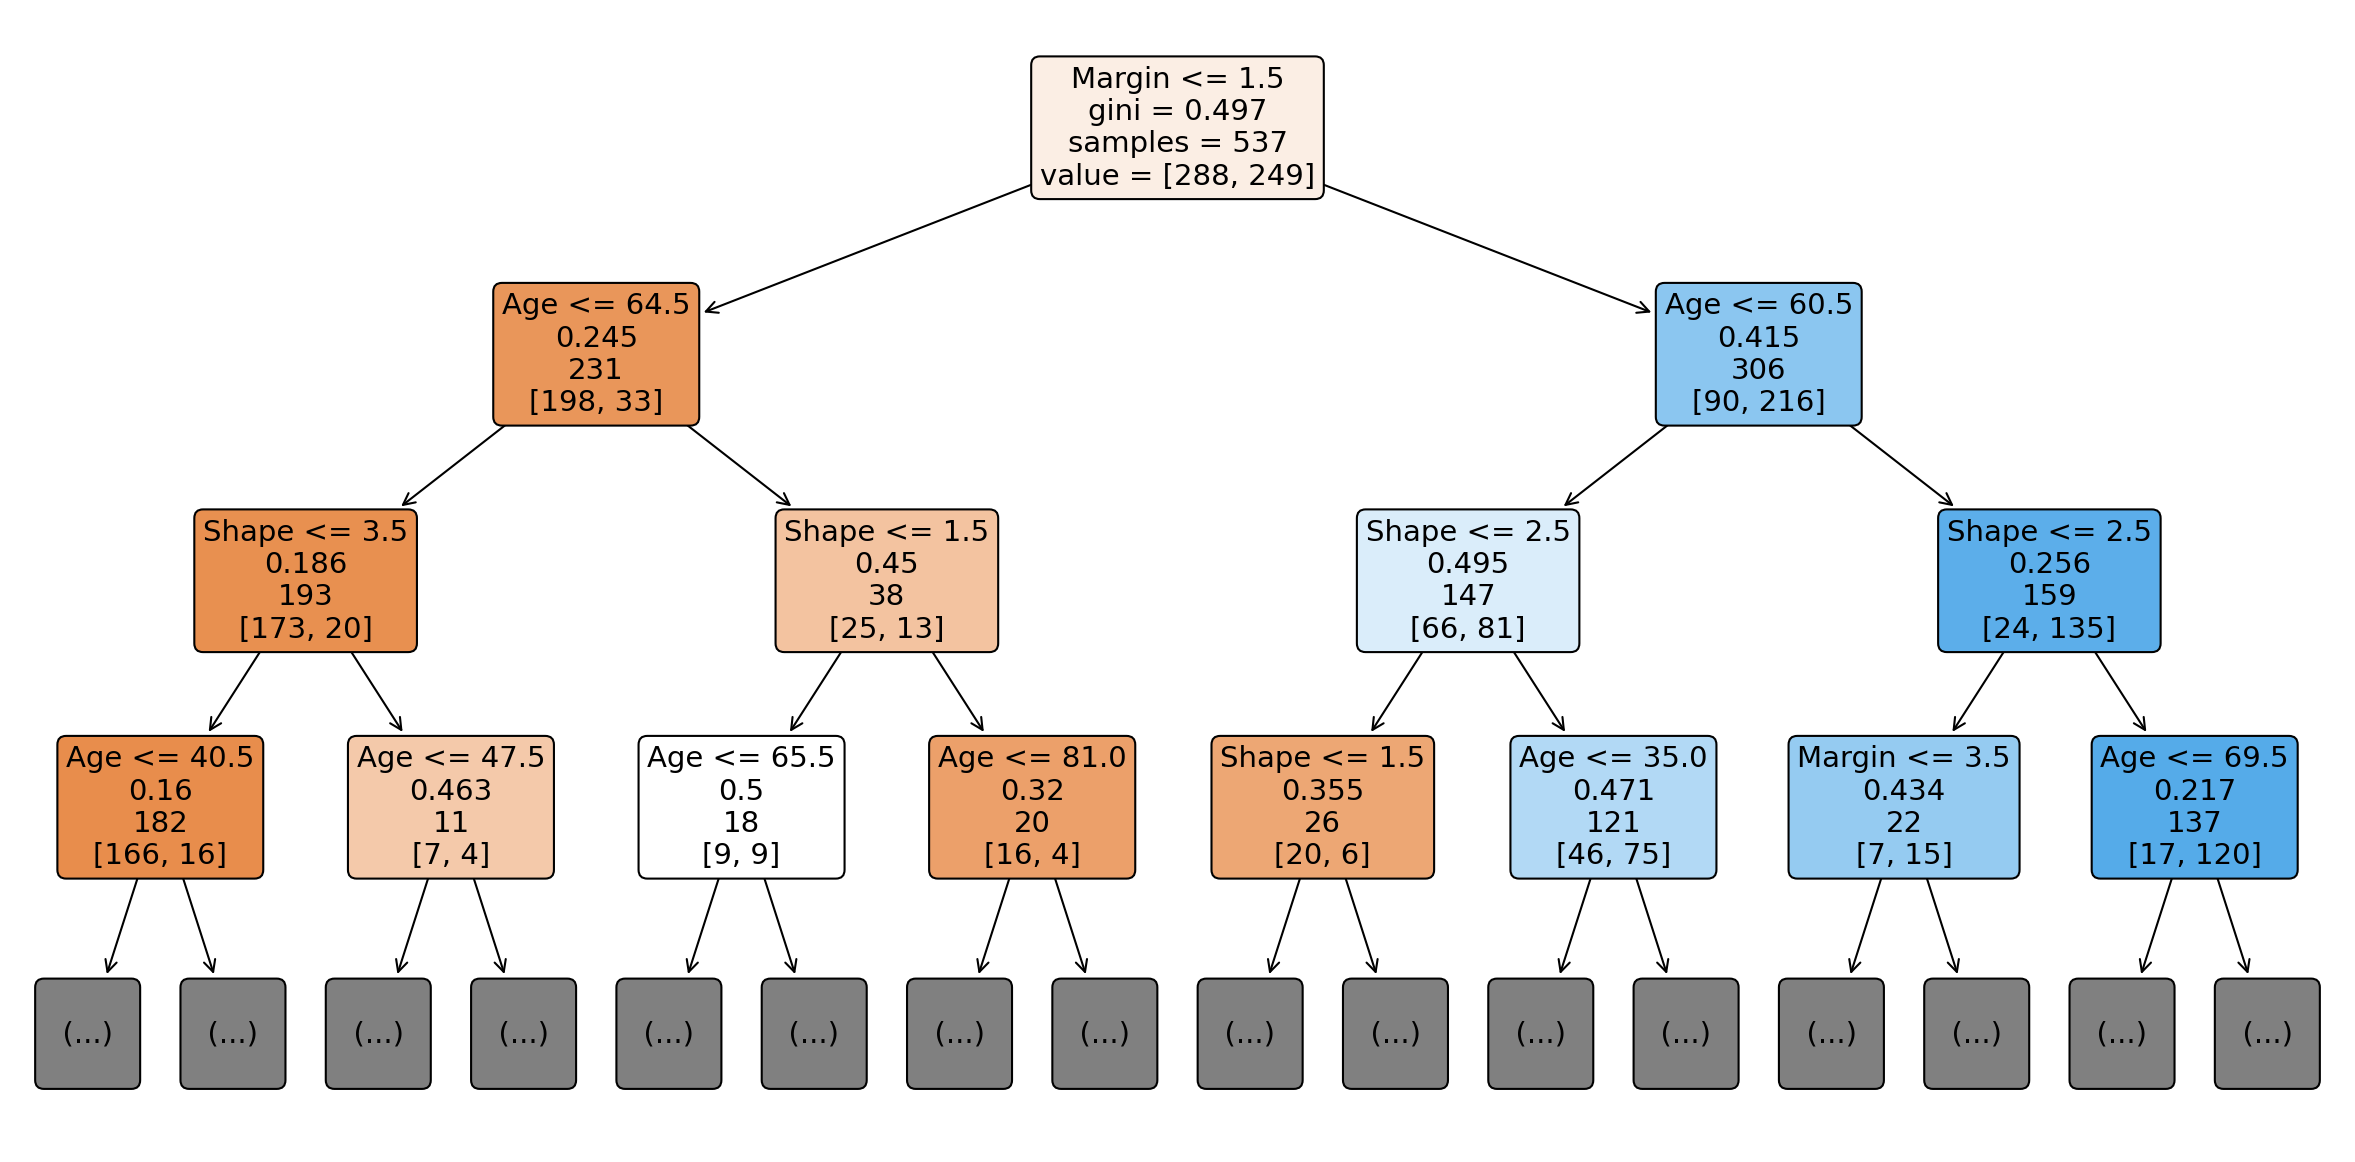

In [17]:
fig, ax = plt.subplots(figsize=(20,10), dpi=150)
ret = tree.plot_tree(clf, ax=ax, feature_names=['Age', 'Shape', 'Margin', 'Density'], fontsize=14, filled=True, label='root', rounded=True, max_depth=3)
plt.savefig('tree_mode.pdf', bbox_inches='tight')

In [18]:
from sklearn.metrics import accuracy_score
train_acc = clf.score(X_train, y_train)
val_acc   = clf.score(X_val, y_val)
test_acc  = clf.score(X_test, y_test)
                           
print(f"Train accuracy: {train_acc:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9069
Validation accuracy: 0.7556
Test accuracy: 0.7118


In [19]:
from sklearn.model_selection import GridSearchCV
grid_searcher = GridSearchCV(clf, {'max_depth': range(4,11,2), 'min_samples_split': range(2,6), 'min_samples_leaf': range(1,6)})
grid_searcher.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(4, 11, 2),
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(2, 6)})

In [20]:
grid_searcher.best_params_

{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [21]:
from sklearn.metrics import accuracy_score
train_acc = accuracy_score(y_train, grid_searcher.predict(X_train))
val_acc   = accuracy_score(y_val,   grid_searcher.predict(X_val))
test_acc  = accuracy_score(y_test,  grid_searcher.predict(X_test))
                           
print(f"Train accuracy: {train_acc:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.8138
Validation accuracy: 0.8667
Test accuracy: 0.7743


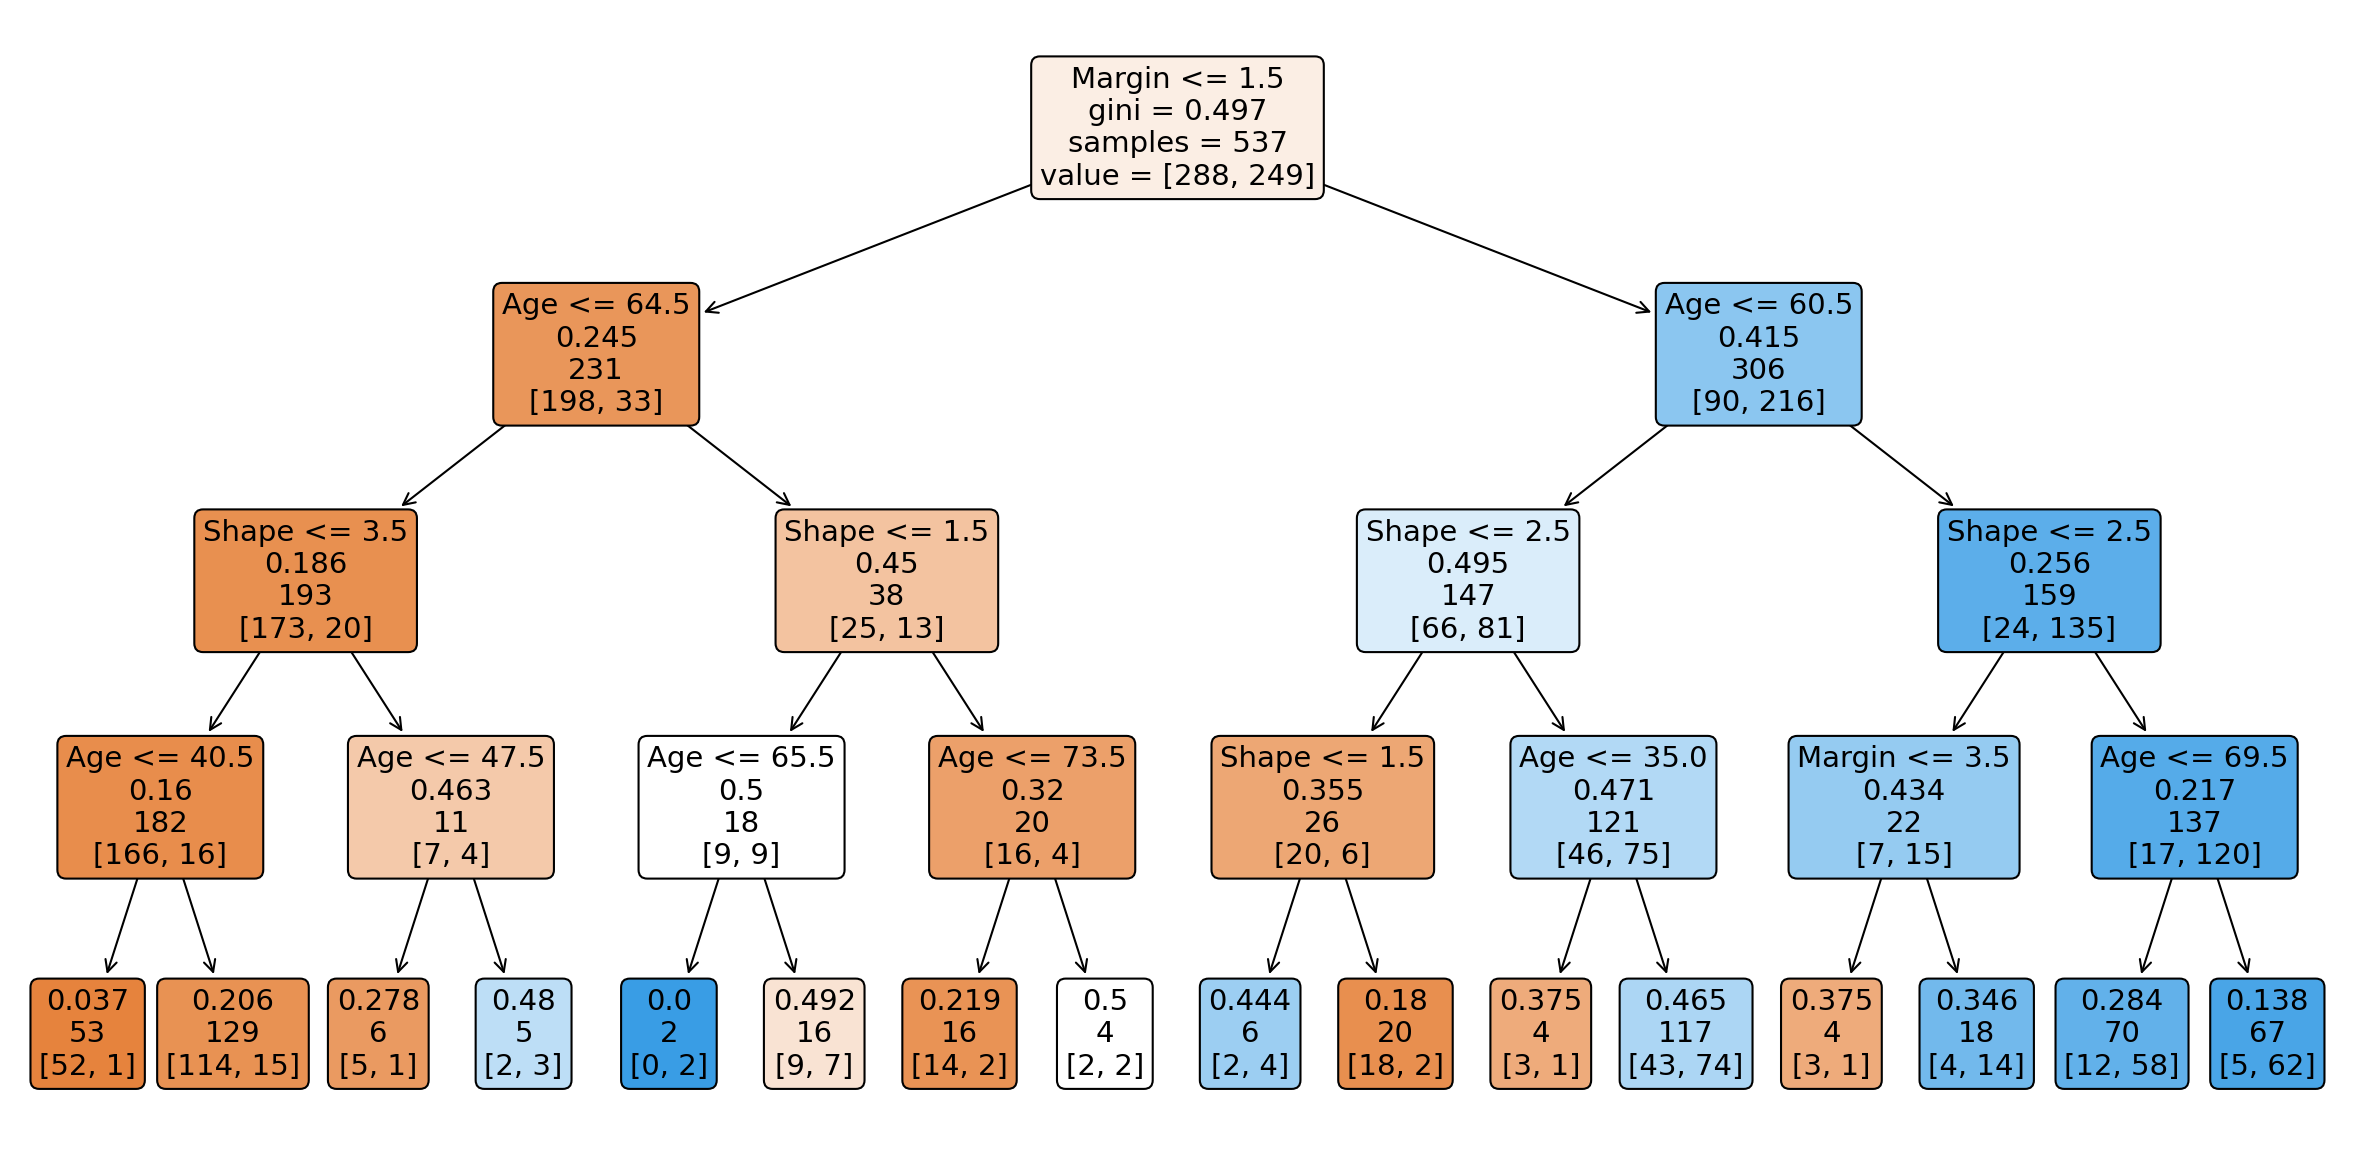

In [22]:
fig, ax = plt.subplots(figsize=(20,10), dpi=150)
ret = tree.plot_tree(grid_searcher.best_estimator_, ax=ax, feature_names=['Age', 'Shape', 'Margin', 'Density'], fontsize=14, filled=True, label='root', rounded=True) 
plt.savefig('tree_optimal_mode.pdf', bbox_inches='tight')

In [23]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

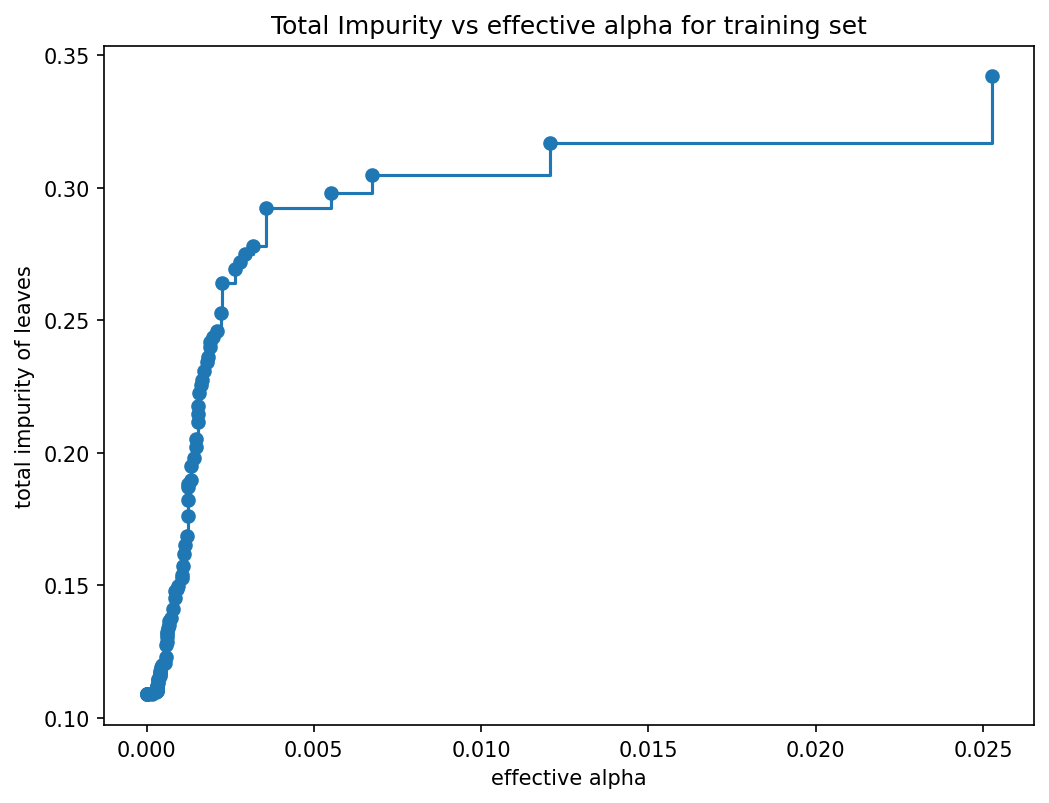

In [24]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.savefig('impurity_vs_alpha_mode.pdf', bbox_inches='tight')

In [25]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.1554069772473765


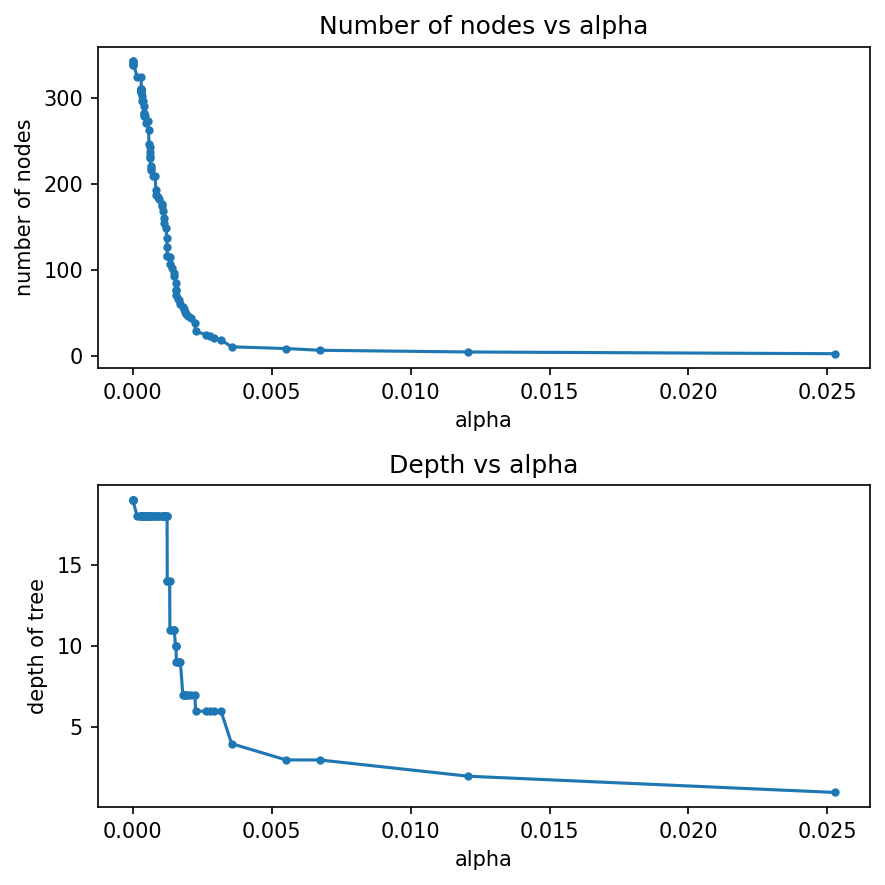

In [26]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(6,6), dpi=150)
ax[0].plot(ccp_alphas, node_counts, marker=".")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker=".")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
plt.savefig('nodes_vs_alpha_mode.pdf', bbox_inches='tight')

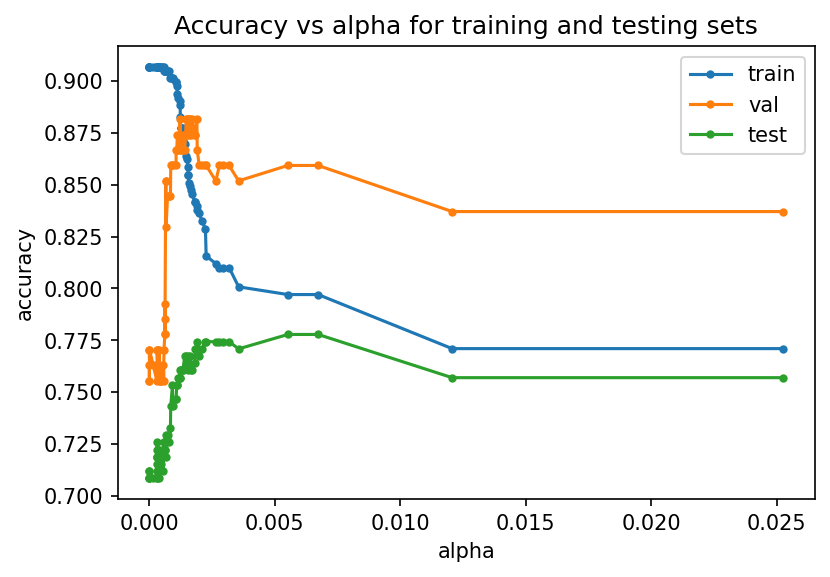

In [27]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
val_scores = [clf.score(X_val, y_val) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(6,4), dpi=150)
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker=".", label="train")
ax.plot(ccp_alphas, val_scores, marker=".", label="val")
ax.plot(ccp_alphas, test_scores, marker=".", label="test")
ax.legend()
plt.savefig('accuracy_vs_alpha_mode.pdf', bbox_inches='tight')

In [28]:
best_tree_idx = np.argmax(val_scores)
print(
    "Number of nodes in the best tree is: {} with ccp_alpha: {}".format(
        clfs[best_tree_idx].tree_.node_count, ccp_alphas[best_tree_idx]
    )
)

Number of nodes in the best tree is: 137 with ccp_alpha: 0.0012262260226956815


In [29]:
best_tree = clfs[best_tree_idx]
best_tree_alpha = ccp_alphas[best_tree_idx]

In [30]:
train_acc = best_tree.score(X_train, y_train)
val_acc = best_tree.score(X_val, y_val)
test_acc = best_tree.score(X_test, y_test)

print(f"Train accuracy on best clf: {train_acc:.4f}")
print(f"Validation accuracy on best clf: {val_acc:.4f}")
print(f"Test accuracy on best clf: {test_acc:.4f}")

Train accuracy on best clf: 0.8883
Validation accuracy on best clf: 0.8815
Test accuracy on best clf: 0.7604


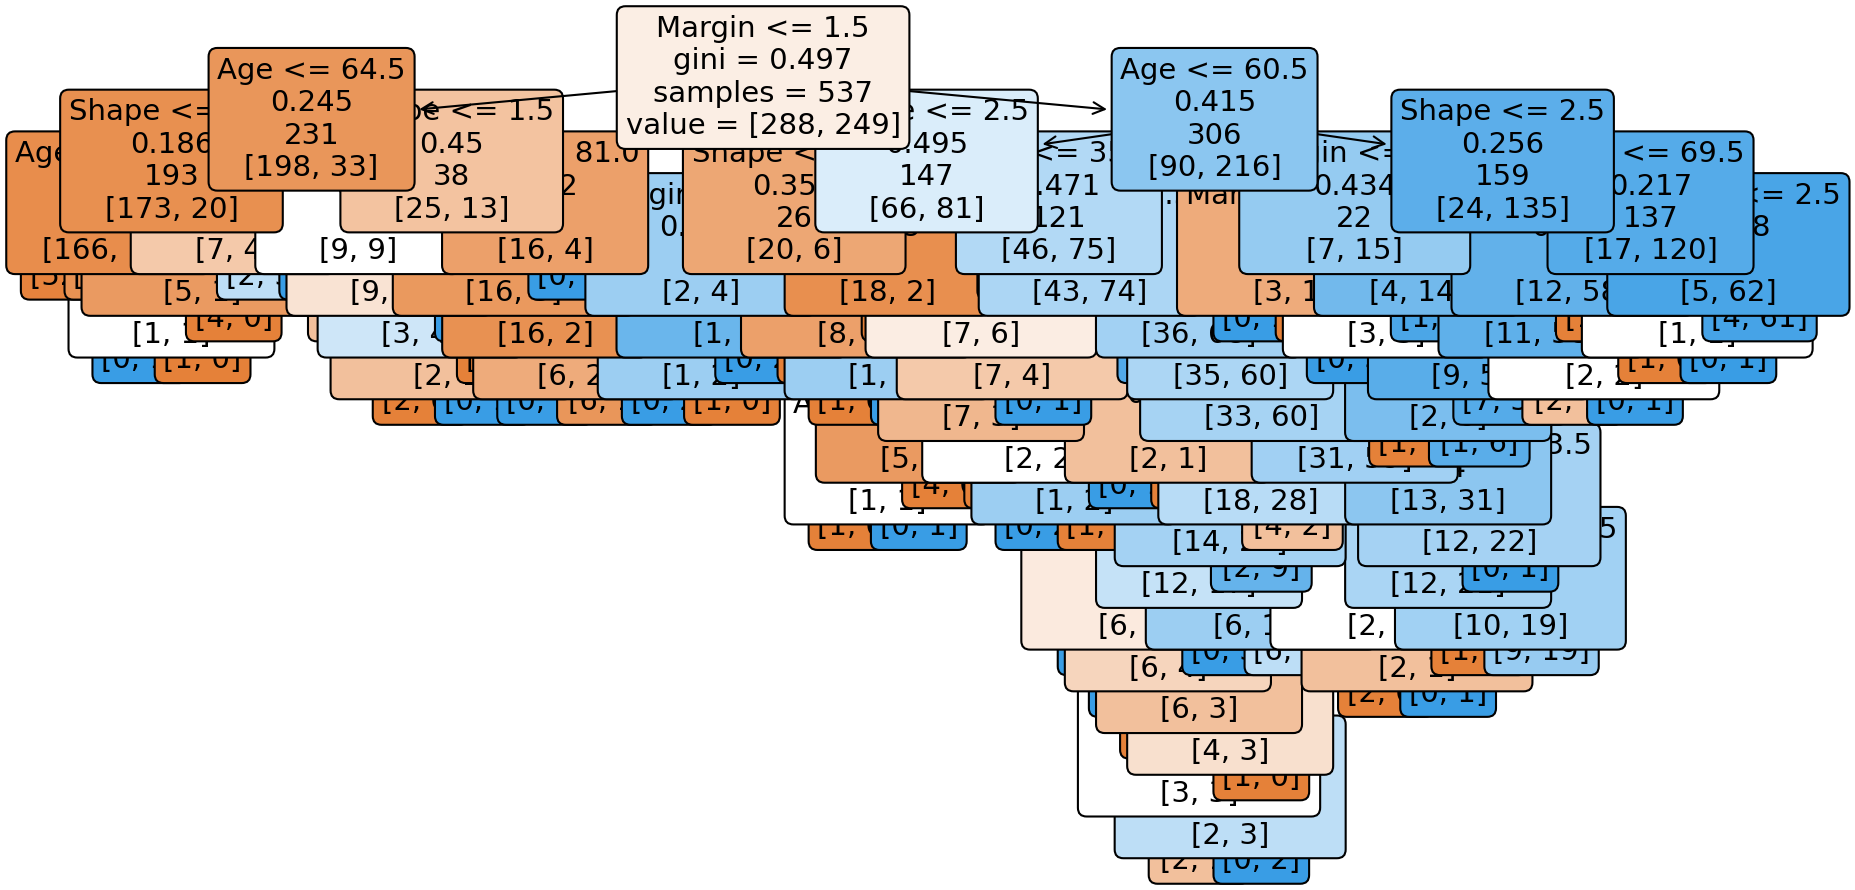

In [31]:
fig, ax = plt.subplots(figsize=(15,7), dpi=150)
ret = tree.plot_tree(best_tree, ax=ax, feature_names=['Age', 'Shape', 'Margin', 'Density'], fontsize=14, filled=True, label='root', rounded=True) 
plt.savefig('tree_best_pruned_mode.pdf', bbox_inches='tight')

In [32]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, oob_score=True)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.8296296296296296

In [33]:
def oob_score(estimator, X_test, y_test):
    return estimator.oob_score_

gs = GridSearchCV(clf, {'n_estimators': range(50,201,50), 'max_features': range(1,5), 'min_samples_split': range(2,6)}, scoring=oob_score)
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(oob_score=True),
             param_grid={'max_features': range(1, 5),
                         'min_samples_split': range(2, 6),
                         'n_estimators': range(50, 201, 50)},
             scoring=<function oob_score at 0x12899cdc0>)

In [34]:
clf_best = gs.best_estimator_
print(f"Train accuracy: {accuracy_score(y_train, clf_best.predict(X_train)):.4f}")
print(f"Out of bag accuracy: {clf_best.oob_score_:.4f}")
print(f"Validation accuracy: {accuracy_score(y_val, clf_best.predict(X_val)):.4f}")
print(f"Test accuracy: {accuracy_score(y_test, clf_best.predict(X_test)):.4f}")


Train accuracy: 0.8808
Out of bag accuracy: 0.7337
Validation accuracy: 0.8370
Test accuracy: 0.7743


In [35]:
gs.best_params_

{'max_features': 2, 'min_samples_split': 5, 'n_estimators': 100}

In [42]:
from xgboost import XGBClassifier

X_train_raw, y_train_raw = no_impute(pd.read_csv(f"{dpath}/train.csv"))
X_val_raw, y_val_raw = no_impute(pd.read_csv(f"{dpath}/val.csv"))
X_test_raw, y_test_raw = no_impute(pd.read_csv(f"{dpath}/test.csv"))

clf = XGBClassifier()
gs = GridSearchCV(clf, {'n_estimators': range(10,51,10), 'subsample': np.arange(0.1,0.61,0.1), 'max_depth': range(4,11)})
gs.fit(X_train_raw, y_train_raw)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                           

In [43]:
gs.best_params_

{'max_depth': 10, 'n_estimators': 10, 'subsample': 0.5}

In [44]:
print(f"Train accuracy: {gs.score(X_train_raw, y_train_raw):.4f}")
print(f"Validation accuracy: {gs.score(X_val_raw, y_val_raw):.4f}")
print(f"Test accuracy: {gs.score(X_test_raw, y_test_raw):.4f}")

Train accuracy: 0.8361
Validation accuracy: 0.8444
Test accuracy: 0.7708
